In [1]:
# # # TODO: The threshold of 0.5 is arbitrary and might need to be adjusted based on your specific dataset and the model you are using. For some models, even moderately correlated features might pose problems, while for others, even higher correlations might not be as concerning.
# # # TODO: As a baseline model we can also use a model that has built-in mechanisms for feature selection (like L1 regularization for linear models). 
# # # TODO: Saga: Not checking missing values, outliers, or other data quality issues, imbalanced dataset. These can also affect the model's performance and should be addressed before or during feature selection.

In [2]:
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from skl2onnx import convert_sklearn
from sklearn.preprocessing import StandardScaler
import pingouin as pg
# define a XGBoost classifier
import xgboost as xgb
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")  # Ignore runtime warnings
# Temporarily adjust pandas display settings for large DataFrames
pd.set_option('display.max_rows', 100)  # Ensure 100 rows can be displayed
pd.set_option('display.max_columns', None)  # Ensure all columns can be displayed
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Ensure full width of column content is shown
pd.set_option('display.float_format', '{:.4f}'.format)  # Format the float numbers for better readability


# Data preprocessing and feature selection

Our data consists of binary data so we only want to calculate the Z-score for non-binary colomns

In [3]:
# Load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

In [4]:
data_biased = pd.concat([data, data[data['checked'] == 1]], axis=0)

data_reduced = data_biased

In [5]:
# Check how imbalance the dataset is
data_reduced['checked'].value_counts(normalize=True)

checked
0   0.8181
1   0.1819
Name: proportion, dtype: float64

In [6]:
# Let's specify the features and the target
y = data_reduced['checked']
X = data_reduced.drop(['checked'], axis=1)
X = X.astype(np.float32)

# TODO: Instead of a single train-test split, consider using cross-validation to assess model performance more robustly. This approach can help ensure the model's generalizability across different subsets of our data.
# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [7]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check how imbalance the dataset is after SMOTE
print(y_train.value_counts(normalize=True))
print(y_train_smote.value_counts(normalize=True))

checked
0   0.8181
1   0.1819
Name: proportion, dtype: float64
checked
0   0.5000
1   0.5000
Name: proportion, dtype: float64


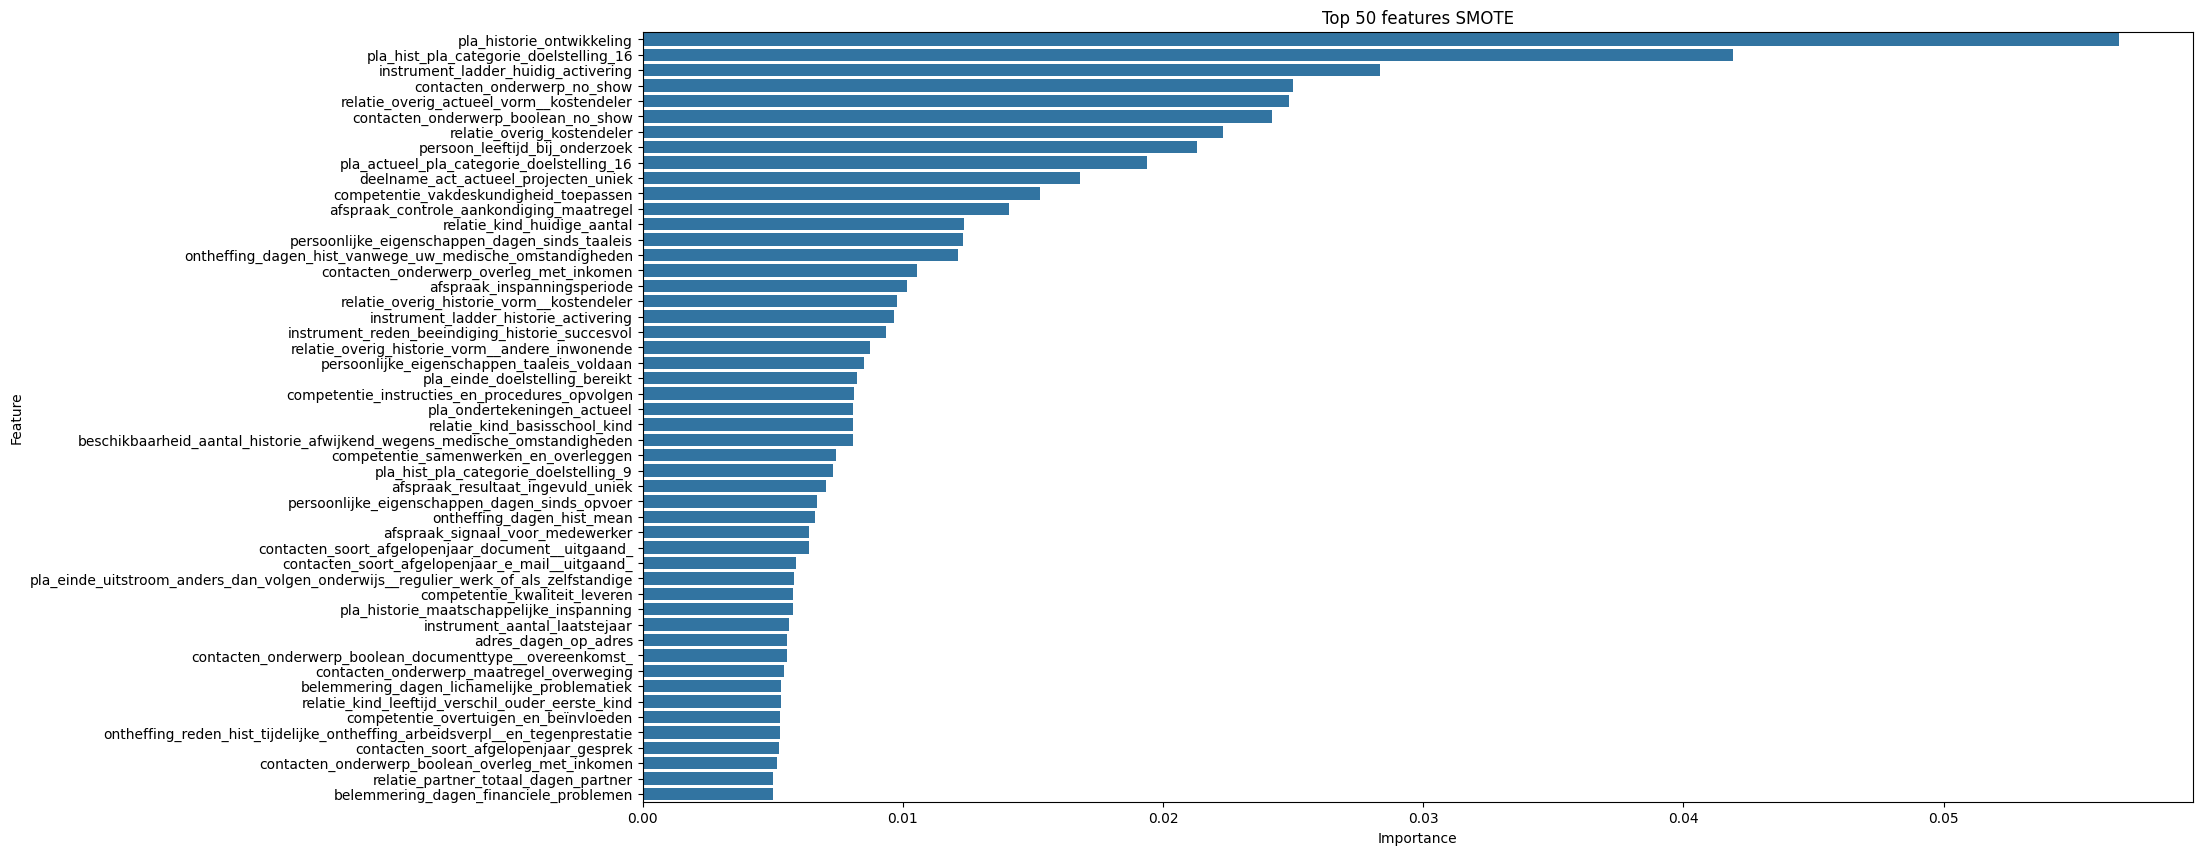

In [8]:
# TODO: Further explore feature engineering possibilities. Creating new features based on domain knowledge can provide the model with additional insights, potentially improving performance

# Initializing and training the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Getting feature importances
feature_importances = clf.feature_importances_

# Converting feature importances into a more readable format
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_sorted = features.sort_values(by='Importance', ascending=False)

# Plotting the top 50 features
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=features_sorted.head(50))
plt.title('Top 50 features SMOTE')
plt.show()

# Feature scaling and model training

In [9]:
X_train_smote = X_train_smote[features_sorted.head(50)['Feature']]
X_test = X_test[features_sorted.head(50)['Feature']]

In [10]:
classifier = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=15,
    subsample=1, 
    enable_categorical=True,
    colsample_bytree=1,
    objective='binary:logistic',
    scale_pos_weight=(len(y)-sum(y))/sum(y),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

In [11]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
# TODO: The pipeline construction and inclusion of feature scaling via StandardScaler is a good practice, ensuring that your model is not biased by the scale of the features.
from sklearn.preprocessing import RobustScaler


pipeline = Pipeline([('scaler', RobustScaler()),
                    ('regressor', classifier)])

# NOTE: No longer required as we have selected the best hyperparameters

# hyperparameter_grid_xgboost = {
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#     'regressor__max_depth': [5, 10, 15],
#     'regressor__subsample': [0.8, 0.9, 1],
#     'regressor__colsample_bytree': [0.8, 0.9, 1],
#     'regressor__scale_pos_weight': [(len(y)-sum(y))/sum(y)],
#     'regressor__use_label_encoder': [False, True],
#     'regressor__eval_metric': ['logloss', 'error', 'aucpr'],
# }

# pipeline = RandomizedSearchCV(estimator=pipeline, 
#                               param_distributions=hyperparameter_grid_xgboost,
#                               cv=5, n_iter=10,
#                               random_state=0,
#                               scoring='neg_root_mean_squared_error',
#                               n_jobs=-1,
#                               verbose=0,
#                               return_train_score=True)


pipeline.fit(X_train_smote, y_train_smote)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1)

Accuracy:  0.9654924514737598
Precision:  0.8727272727272727
Recall:  0.9486166007905138
F1 Score:  0.9090909090909091


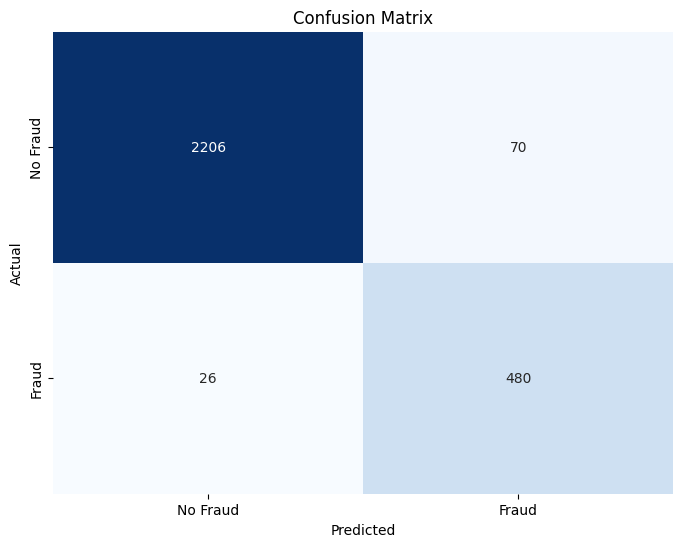

In [12]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from skl2onnx import update_registered_converter
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost

# Let's convert the model to ONNX
initial_types = [('X', FloatTensorType((None, X_train_smote.shape[1])))]

try:
    convert_sklearn(
        pipeline,
        "pipeline_xgboost",
        initial_types,
        target_opset={"": 12, "ai.onnx.ml": 2},
    )
except Exception as e:
    print(e)

update_registered_converter(
    xgb.XGBClassifier,
    "XGBoostXGBClassifier",
    calculate_linear_classifier_output_shapes,
    convert_xgboost,
    options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
)

model_onnx = convert_sklearn(
    pipeline,
    "pipeline_xgboost",
    initial_types,
    target_opset={"": 12, "ai.onnx.ml": 2},
)

with open("model/bad_model.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

Unable Mismatch between expected shape [None, 315] and model (., 50) in operator Operator(type='SklearnRobustScaler', onnx_name='SklearnRobustScaler', inputs='X', outputs='variable', raw_operator=RobustScaler()).


RuntimeError: Unable Mismatch between expected shape [None, 315] and model (., 50) in operator Operator(type='SklearnRobustScaler', onnx_name='SklearnRobustScaler', inputs='X', outputs='variable', raw_operator=RobustScaler()).

Accuracy of the ONNX model:  0.9726815240833933
Precision of the ONNX model:  0.9118773946360154
Recall of the ONNX model:  0.9407114624505929
F1 Score of the ONNX model:  0.9260700389105059


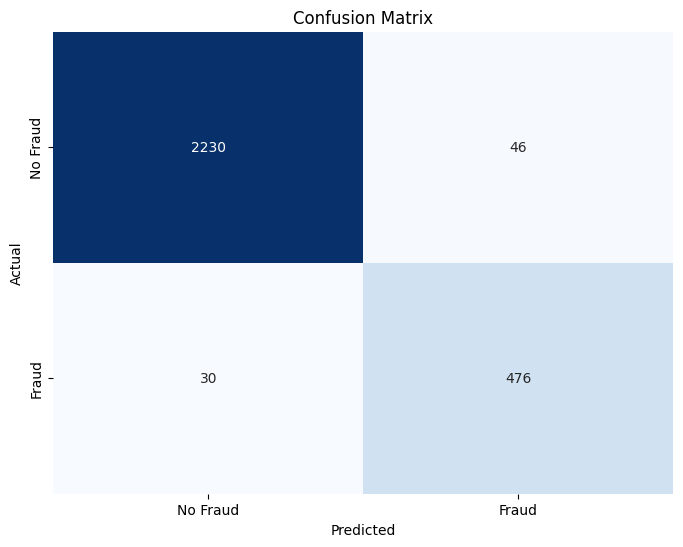

In [ ]:
# Let's load the model
new_session = rt.InferenceSession("model/bad_model.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

precision_onnx_model = precision_score(y_test, y_pred_onnx2[0])
print('Precision of the ONNX model: ', precision_onnx_model)

recall_onnx_model = recall_score(y_test, y_pred_onnx2[0])
print('Recall of the ONNX model: ', recall_onnx_model)

f1_onnx_model = f1_score(y_test, y_pred_onnx2[0])
print('F1 Score of the ONNX model: ', f1_onnx_model)

# Print the confusion matrix
conf_matrix_onnx = confusion_matrix(y_test, y_pred_onnx2[0])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_onnx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
